In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator


import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


[628. 542. 374. 480.]
[0 1 2 3]


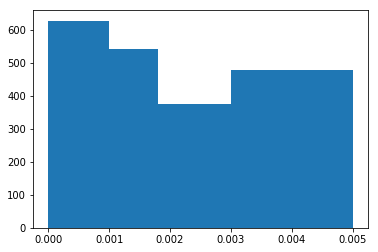

In [235]:
spot_coverages = np.load('data/all_fs.npy')

# bin_edges = np.linspace(0, spot_coverages.max(), 5)
bin_edges = [0, 0.001, 0.0018, 0.003, 0.005] # [0, 0.0018, 0.005] #[0, 0.001, 0.002, 0.005]#

n = plt.hist(spot_coverages, bin_edges)[0]; 
print(n)
bin_inds = np.digitize(spot_coverages, bin_edges, right=True) - 1
print(np.unique(bin_inds))

In [236]:
#train_X = np.load('data/residuals.npy')[:-1, :, np.newaxis]
train_X = np.load('data/regressed.npy').T[:, :-1, np.newaxis]

train_Y = bin_inds

print('Training data shape : ', train_X.shape, train_Y.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

train_X = train_X.astype('float32')

from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)

Training data shape :  (2024, 1498, 1) (2024,)
Total number of outputs :  4
Output classes :  [0 1 2 3]


In [237]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=0)

In [238]:
train_label.sum(0)

array([513., 427., 304., 375.], dtype=float32)

In [239]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1619, 1498, 1), (405, 1498, 1), (1619, 4), (405, 4))

In [240]:
alpha = 0.1
kernel_size = 5
dropout_rate = 0.5
activation = 'linear'
padding = 'same'
pool_size = 2

batch_size = 64
epochs = 50
num_classes = train_Y_one_hot.shape[1]

model = Sequential()

# First layer
model.add(Conv1D(filters=32, kernel_size=kernel_size, activation=activation, 
                 input_shape=(train_X.shape[1], 1), padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(pool_size=pool_size, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Second layer
model.add(Conv1D(filters=64, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(pool_size=pool_size, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Third layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# # fourth layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# # fifth layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# # sixth layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization())

# Fully connected layer 2
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization())

# Fully connected layer 2
# model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [241]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 1498, 32)          192       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 1498, 32)          0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 749, 32)           0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 749, 32)           128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 749, 32)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 749, 64)           10304     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 749, 64)           0         
__________

In [242]:
train = model.fit(train_X, train_label, batch_size=batch_size, 
                  epochs=epochs, validation_data=(valid_X, valid_label))

Train on 1619 samples, validate on 405 samples
Epoch 1/50
1619/1619 [==============================] - 7s 5ms/step - loss: 1.7759 - acc: 0.3428 - val_loss: 3.0613 - val_acc: 0.2247
Epoch 2/50
1619/1619 [==============================] - 5s 3ms/step - loss: 1.3216 - acc: 0.4077 - val_loss: 1.4187 - val_acc: 0.4444
Epoch 3/50
1619/1619 [==============================] - 4s 3ms/step - loss: 1.1885 - acc: 0.4534 - val_loss: 1.4039 - val_acc: 0.3901
Epoch 4/50
1619/1619 [==============================] - 5s 3ms/step - loss: 1.0996 - acc: 0.5022 - val_loss: 1.2164 - val_acc: 0.5235
Epoch 5/50
1619/1619 [==============================] - 6s 4ms/step - loss: 1.0308 - acc: 0.5423 - val_loss: 1.1472 - val_acc: 0.5210
Epoch 6/50
1619/1619 [==============================] - 5s 3ms/step - loss: 0.9464 - acc: 0.5868 - val_loss: 1.4317 - val_acc: 0.4074
Epoch 7/50
1619/1619 [==============================] - 5s 3ms/step - loss: 0.8802 - acc: 0.6368 - val_loss: 1.2883 - val_acc: 0.4444
Epoch 8/50
1619

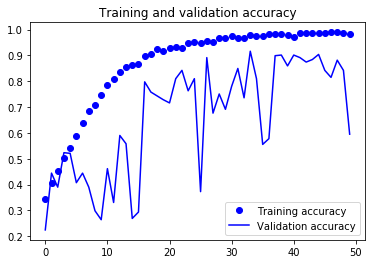

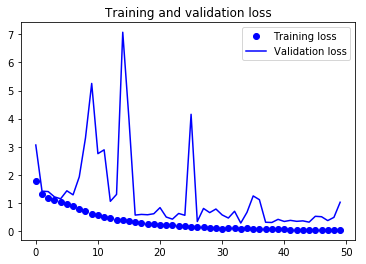

In [243]:
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [244]:
model.save('data/model.hdf5')

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

from matplotlib.ticker import MultipleLocator

In [246]:

# model = load_model('data/model.hdf5')

In [247]:
all_residuals = np.load('data/regressed.npy').T[:, :, np.newaxis]
wavelengths = np.load('data/regressed_wl.npy')


In [248]:
wavelengths.shape, all_residuals.shape

((1499,), (2024, 1499, 1))

In [249]:
pred_y

array([[9.9890018e-01, 1.0828031e-03, 1.7026112e-05]], dtype=float32)

In [250]:
# low_spots = all_residuals[pred_y.argmax(1) == 0]
# mid_spots = all_residuals[pred_y.argmax(1) == 1]
# high_spots = all_residuals[pred_y.argmax(1) == 2]
# most_spots = all_residuals[pred_y.argmax(1) == 3]
pred_y = model.predict(all_residuals[:, :-1, :])

thresh = 0.999
low_spots = all_residuals[pred_y[:, 0] > thresh]
mid_spots = all_residuals[pred_y[:, 1] > thresh]
high_spots = all_residuals[pred_y[:, 2] > thresh]
# most_spots = all_residuals[pred_y[:, 3] > thresh]

In [251]:
for i in [low_spots, mid_spots, high_spots]:
    print(len(i))

38
85
83


In [252]:
median_resid = np.median(all_residuals, axis=0)

In [253]:
np.unique(pred_y.argmax(1))

array([0, 1, 2, 3])

In [254]:
xlims = [[5162, 5163], 
         [5167.2, 5168.2], 
         [5168.5, 5170], 
         [5171.5, 5172.2],
         [5172.5, 5174.5]] # [5176.5, 5177.2]]#,
         #]

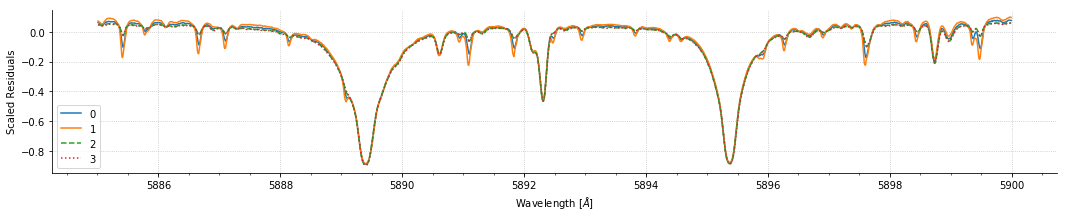

In [255]:
fig, ax = plt.subplots(figsize=(18, 3), sharex=True)

props = dict(alpha=1)

ax.plot(wavelengths, np.median(low_spots[:, :, 0].T, axis=1) , label='0', **props);

ax.plot(wavelengths, np.median(mid_spots[:, :, 0].T, axis=1) , label='1', **props); # - median_resid[:, 0]

ax.plot(wavelengths, np.median(high_spots[:, :, 0].T, axis=1) , ls='--', label='2', **props);

ax.plot(wavelengths, np.median(most_spots[:, :, 0].T, axis=1) , ls=':', label='3', **props);

# for xlim in xlims: 
#     ax.axvspan(*xlim, color='silver', alpha=0.1)

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
ax.grid(ls=':', color='silver')
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.set_xlim([5160, 5178])
# ax.set_ylim([-0.01, 0.01])
ax.set(xlabel='Wavelength [$\AA$]', ylabel='Scaled Residuals')
plt.legend()
# fig.savefig('plots/solar_categories.png', bbox_inches='tight', dpi=300)

In [227]:
# fig, ax = plt.subplots(1, len(xlims), figsize=(8, 3), sharey=True)

# for i, xlim in enumerate(xlims):

#     props = dict(alpha=1)

#     ax[i].plot(wavelengths, np.median(low_spots[:, :, 0].T, axis=1), label='0', **props);

#     ax[i].plot(wavelengths, np.median(mid_spots[:, :, 0].T, axis=1), label='1', **props);

#     ax[i].plot(wavelengths, np.median(high_spots[:, :, 0].T, axis=1), ls='--', label='2', **props);

#     ax[i].plot(wavelengths, np.median(most_spots[:, :, 0].T, axis=1), ls=':', label='3', **props);

#     ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
#     ax[i].set_xlim(xlim)
#     ax[i].grid(ls=':', color='silver')
#     plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')
#     ax[i].ticklabel_format(useOffset=False)
    
# ax[0].set(ylabel='Scaled Residuals')
# fig.text(0.5, -0.01, 'Wavelength [$\AA$]', ha='center')
# # ax[-1].legend(loc=(1.1, 0.2))#loc='upper left')
# fig.tight_layout(w_pad=-2)
# plt.show()
# # fig.savefig('plots/focus1.pdf', bbox_inches='tight')

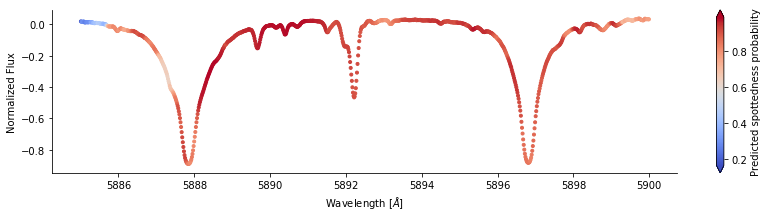

In [264]:
colors = []
window = 500
x = np.arange(len(wavelengths))

x_interps = []
y_not_interps = []
pred_ys = []

# no_spots = np.median(low_spots[:, :, 0].T, axis=1)
# mid_spots = np.median(mid_spots[:, :, 0].T, axis=1)

test = np.median(high_spots[:, :, 0].T, axis=1)  # np.median(high_spots[:, :, 0].T, axis=1)  # np.median(mid_spots[:, :, 0].T, axis=1)  

for i in range(window//2, len(wavelengths)-window//2):
    sliced = np.r_[0:i-window//2, i+window//2:len(wavelengths)]

    y_interped = np.interp(x, x[sliced], test[sliced])#  median_residuals[sliced])

    pred_y = model.predict(y_interped[np.newaxis, :-1, np.newaxis])

    x_interps.append(x[i])
    y_not_interps.append(test[i])
    pred_ys.append(pred_y[0, 2])#pred_y.argmax(1)[0])

fig, ax = plt.subplots(figsize=(14, 3))
cax = plt.scatter(np.linspace(wavelengths.min(), wavelengths.max(), len(wavelengths)-window), 
                  y_not_interps, c=pred_ys, marker='.',
                  cmap=plt.cm.coolwarm)#, vmin=0, vmax=1)# vmax=nClasses-1)
cbar = plt.colorbar(cax, extend='both')

ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('Normalized Flux')
cbar.set_label('Predicted spottedness probability')
# ax.set_xlim([wl_fit_min, wl_fit_max])
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
#     fig.savefig('plots/focus2.pdf', bbox_inches='tight')
#     plt.savefig('plots/focus2.png', bbox_inches='tight', dpi=200)
plt.show()

In [245]:
# fig, ax = plt.subplots(figsize=(8, 3), sharex=True)

# props = dict(alpha=1)


# ax.plot(wavelengths, np.median(low_spots[:, :, 0].T, axis=1) - np.median(mid_spots[:, :, 0].T, axis=1), label='Some spots', **props);

# ax.plot(wavelengths, np.median(high_spots[:, :, 0].T, axis=1) - np.median(mid_spots[:, :, 0].T, axis=1), ls='--', label='Many spots', **props);

# ax.plot(wavelengths, np.median(most_spots[:, :, 0].T, axis=1) - np.median(mid_spots[:, :, 0].T, axis=1), ls='--', label='Most spots', **props);

# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.set_xlim([5160, 5178])
# ax.set(xlabel='Wavelength [$\AA$]', ylabel='Scaled Residuals')

# plt.legend()

In [102]:
# fig, ax = plt.subplots(3, 1, figsize=(14, 4), sharex=True)

# props = dict(alpha=0.01)

# plt.plot(low_spots[:, :, 0].T, color='C0', **props);

# plt.plot(mid_spots[:, :, 0].T, color='C1', **props);

# plt.plot(high_spots[:, :, 0].T, color='C2', **props);